**Lab meeting - RNN practical**

w/ simple classification task with different spatial embeddings
looking at different output measurements

**Danyal Akarca, 05/03/24**

In [62]:
#### Import ####

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import community as community_louvain
import scipy as scipy

In [63]:
#### Build task ####

# generate synthetic data and labels
def generate_data(num_sequences, sequence_length, threshold):
    data = np.random.rand(num_sequences, sequence_length)
    labels = np.mean(data, axis=1) > threshold
    return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

In [64]:
#### Build RNN ####

class DecisionRNN(nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
         super(DecisionRNN, self).__init__()
         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
         self.fc = nn.Linear(hidden_size, output_size)
    
     def forward(self, x):
         out, _ = self.rnn(x)
         out = self.fc(out[:, -1, :]) # Get the last time step output
         return torch.sigmoid(out) # Where to define the activation function: depends on task (note some are negative)
# for example, torch.relu(out) or torch.tanh(out)

In [65]:
#### Set parameters ####

num_sequences = 1000
sequence_length = 10
threshold = 0.5
input_size = 1
hidden_size = 50
output_size = 1
num_epochs = 200

In [66]:
#### Prepare task data ####

# data preparation
data, labels = generate_data(num_sequences, sequence_length, threshold)
data = data.view(num_sequences, sequence_length, -1) # Reshape for RNN [batch, seq, feature]

# train/test split
train_size = int(0.8 * num_sequences)
test_data = data[train_size:]
test_labels = labels[train_size:]
data, labels = data[:train_size], labels[:train_size]

In [67]:
#### Define spatial embedding ####

# #### 3d grid ####
# # Calculate the cube root
# grid_side = int(np.cbrt(hidden_size))  # Calculate the side length of the cube grid

# # Check if hidden_size is a perfect cube
# if grid_side ** 3 != hidden_size:
#     raise ValueError("Hidden size must be a perfect cube for a cubic grid layout.")

# # Generate grid positions for each node in 3D
# x, y, z = np.meshgrid(range(grid_side), range(grid_side), range(grid_side))
# positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T

# # Initialize an empty matrix to store distances in 3D
# distance_matrix_np = np.zeros((hidden_size, hidden_size))

# # Compute Euclidean distances in 3D
# for i in range(hidden_size):
#     for j in range(hidden_size):
#         distance_matrix_np[i, j] = np.linalg.norm(positions[i] - positions[j])

# # Convert the 3D distance matrix
# distance_matrix = torch.tensor(distance_matrix_np, dtype=torch.float32)

#### 3d sphere volume ####
# def uniform_inside_sphere(num_points):
#     # Generate uniform angles
#     phi = np.random.uniform(0, 2 * np.pi, num_points)
#     costheta = np.random.uniform(-1, 1, num_points)
#     u = np.random.uniform(0, 1, num_points)
    
#     # Convert to spherical coordinates
#     theta = np.arccos(costheta)
#     r = u ** (1./3.)  # Cube root to ensure uniform distribution within the volume
    
#     # Convert to cartesian coordinates
#     x = r * np.sin(theta) * np.cos(phi)
#     y = r * np.sin(theta) * np.sin(phi)
#     z = r * np.cos(theta)
    
#     return np.vstack((x, y, z)).T

# positions = uniform_inside_sphere(hidden_size)

# # Initialize an empty matrix to store distances in 3D
# distance_matrix_np = np.zeros((hidden_size, hidden_size))

# # Compute Euclidean distances in 3D
# for i in range(hidden_size):
#     for j in range(hidden_size):
#         distance_matrix_np[i, j] = np.linalg.norm(positions[i] - positions[j])

# # Convert the 3D distance matrix to a PyTorch tensor
# distance_matrix = torch.tensor(distance_matrix_np, dtype=torch.float32)

#### 3d sphere surface ####
def fibonacci_sphere(samples=1000):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # Golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points.append((x, y, z))

    return np.array(points)

positions = fibonacci_sphere(hidden_size)  # Generate positions within a unit sphere

# Initialize an empty matrix to store distances in 3D
distance_matrix_np = np.zeros((hidden_size, hidden_size))

# Compute Euclidean distances in 3D
for i in range(hidden_size):
    for j in range(hidden_size):
        distance_matrix_np[i, j] = np.linalg.norm(positions[i] - positions[j])

# Convert the 3D distance matrix to a PyTorch tensor
distance_matrix = torch.tensor(distance_matrix_np, dtype=torch.float32)

In [68]:
#### Initialize the model, loss criterion, and optimizer ####

model = DecisionRNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

# Freeze input-to-hidden weights and bias
for name, param in model.rnn.named_parameters():
    if 'weight_ih' in name or 'bias_ih' in name:
        param.requires_grad = False

# Also freeze hidden-output weights and bias if we want to
#for param in model.fc.parameters():
#    param.requires_grad = False

# Make some input-hidden weights zero (e.g., this makes first half zero)
# with torch.no_grad():
#     # Example: Set the first half of the input-hidden weights to zero
#     num_weights_to_zero = model.rnn.weight_ih_l0.size(1) // 2
#     model.rnn.weight_ih_l0[:, :num_weights_to_zero] = 0.0

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)    

In [69]:
#### Apply weight initialisations to the hidden weights (default Uniform) ####

#### Initialise structure, rank, topology, populations, etc

# mean = 0.0  # Mean of the Gaussian distribution
# std_dev = 1.0  # Standard deviation of the Gaussian distribution
# with torch.no_grad():  # Ensure no gradients are computed during weight initialization
#     model.rnn.weight_hh_l0.normal_(mean, std_dev)
    
# Parameters for the log-normal distribution
#mean = 0.0  # Mean of the underlying normal distribution
#std_dev = 1.0  # Standard deviation of the underlying normal distribution
#with torch.no_grad():  # Ensure no gradients are computed during this operation
#    model.rnn.weight_hh_l0.data.normal_(mean, std_dev).exp_()

In [70]:
#### regularisation strength ####
lambda_ = .02

In [71]:
### Initialise lists ####

# Lists to store metrics over epochs
#hidden_states_over_epochs = []
epoch_losses = []
absolute_weight_sums = []
weight_variances = []
correlation_coefficients = []
epoch_accuracies = []
modularity_q = []

# Capture the initial weights
initial_rnn_ih_weights = model.rnn.weight_ih_l0.detach().clone().numpy() # input-hidden 
initial_rnn_hh_weights = model.rnn.weight_hh_l0.detach().clone().numpy() # hidden-hidden
initial_rnn_ho_weights = model.fc.weight.detach().clone().numpy() # For hidden-output weights

# at a minimum - the initialised network could be randomly generated with spatial proximity. 
# Then later the network prunes!

In [72]:
### Training loop ####

for epoch in range(num_epochs):
    
    # Training mode
    model.train()
    optimizer.zero_grad()
    
    # Run the model (not recording activity)
    outputs = model(data)
    
    # Generate the task loss
    loss = criterion(outputs.squeeze(), labels)
    
    #### Custom regulariser ####
    
    # Get the absolute values of the hidden weights
    w_abs = model.rnn.weight_hh_l0.abs()
    
    # get numpy absolute weights
    w_abs_np = np.abs(model.rnn.weight_hh_l0.detach().numpy())
    # calculate the degree matrix S
    S = np.diag(np.sum(w_abs_np, axis=1))
    # compute the inverse square root of S
    S_inv_sqrt = np.linalg.inv(np.sqrt(S))
    # compute the normalized adjacency matrix
    adj = S_inv_sqrt @ w_abs_np @ S_inv_sqrt
    # compute the matrix exponential of the normalized adjacency matrix
    C = scipy.linalg.expm(adj)
    # convert the communicability matrix to a PyTorch tensor
    comm_matrix = torch.tensor(C, dtype=torch.float32)
    
    # Compute the element-wise product to make the structural loss
    structural_loss = w_abs * comm_matrix * distance_matrix
    
    # Sum the element-wise product to form the regularization term
    regularization_term = structural_loss.sum()
    
    # Scale the regularization term by lambda and add it to the task loss
    total_loss = loss + lambda_ * regularization_term
    
    # Perform backpropagation and update weights
    total_loss.backward()
    optimizer.step()
    
    #### Record values over epochs ####
    
    # Record the total loss for analysis
    epoch_losses.append(total_loss.item())
    
    # Calculate and record the absolute sum and variance of weights
    abs_weight_sum = sum(p.abs().sum().item() for p in model.rnn.parameters())
    absolute_weight_sums.append(abs_weight_sum)
    
    weight_variance = sum(p.var().item() for p in model.rnn.parameters())
    weight_variances.append(weight_variance)
    
    # Calculate and record the correlation between weights and distances
    hidden_weights = model.rnn.weight_hh_l0.detach().numpy().flatten()
    distance_matrix_3d = distance_matrix.numpy().flatten()
    correlation_coefficient = np.corrcoef(np.abs(hidden_weights), distance_matrix_3d)[0, 1]
    correlation_coefficients.append(correlation_coefficient)
    
    # Calculate the modularity
    hidden_weights_abs = np.abs(model.rnn.weight_hh_l0.detach().numpy())
    # Convert the weights matrix into a NetworkX graph
    G = nx.from_numpy_array(hidden_weights_abs, create_using=nx.DiGraph)
    # Use the Louvain method to find the best partition
    partition = community_louvain.best_partition(G.to_undirected())
    # Calculate the modularity of this partition
    modularity = community_louvain.modularity(partition, G.to_undirected())
    modularity_q.append(modularity)
    
    # Calculate accuracy
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(test_data).squeeze()
        predicted_labels = outputs > 0.5
        accuracy = (predicted_labels == test_labels).float().mean()
    model.train()  # Set the model back to training mode
    
    # Record accuracy
    epoch_accuracies.append(accuracy.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Absolute Weight Sum: {abs_weight_sum}, Weight Variance: {weight_variance}')

# Capture the final weights
final_rnn_ih_weights = model.rnn.weight_ih_l0.detach().clone().numpy() # final input-hidden weights
final_rnn_hh_weights = model.rnn.weight_hh_l0.detach().clone().numpy() # final hidden-hidden weights
final_rnn_ho_weights = model.fc.weight.detach().clone().numpy()  # Assuming model.fc is your hidden to output linear layer

Epoch [10/200], Loss: 0.686694324016571, Absolute Weight Sum: 167.6103036403656, Weight Variance: 0.026523100677877665
Epoch [20/200], Loss: 0.6824253797531128, Absolute Weight Sum: 149.12946605682373, Weight Variance: 0.025711577851325274
Epoch [30/200], Loss: 0.6742051839828491, Absolute Weight Sum: 133.69869685173035, Weight Variance: 0.02494592498987913
Epoch [40/200], Loss: 0.6417631506919861, Absolute Weight Sum: 124.39337921142578, Weight Variance: 0.024273301474750042
Epoch [50/200], Loss: 0.4555792510509491, Absolute Weight Sum: 127.61420726776123, Weight Variance: 0.02394948247820139
Epoch [60/200], Loss: 0.4385018050670624, Absolute Weight Sum: 120.83443641662598, Weight Variance: 0.02365183155052364
Epoch [70/200], Loss: 0.42107048630714417, Absolute Weight Sum: 117.55113530158997, Weight Variance: 0.023503060219809413
Epoch [80/200], Loss: 0.39974895119667053, Absolute Weight Sum: 114.96398973464966, Weight Variance: 0.023369832895696163
Epoch [90/200], Loss: 0.37738049030

In [73]:
### Evaluation ####

model.eval()
with torch.no_grad():
    predictions = model(test_data).squeeze()
    predicted_labels = predictions > 0.5
    accuracy = (predicted_labels == test_labels).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')

Test Accuracy: 0.9200000166893005


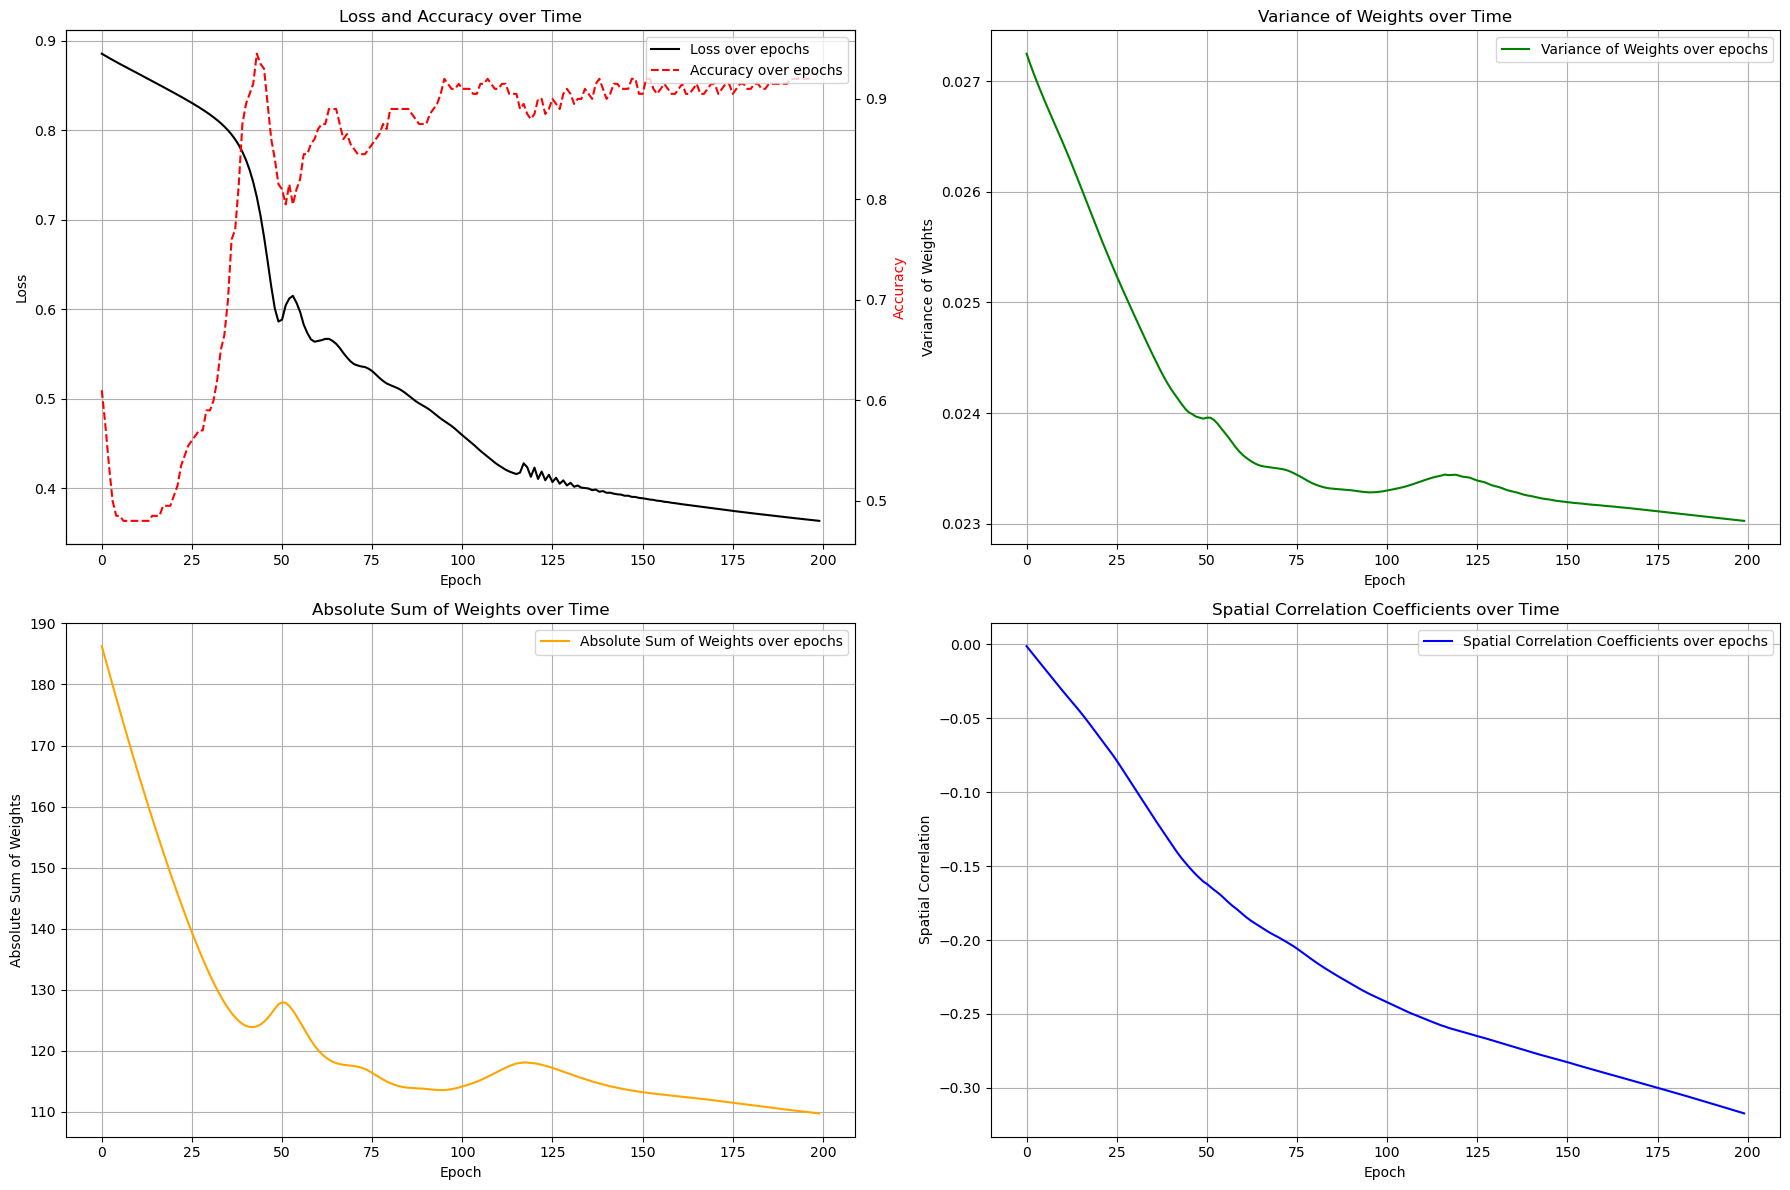

In [74]:
### Visualise: initial loss, weights, space ####

# Initial diagnostics
fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Define a 2x2 grid of subplots

# Loss and Accuracy over Time with Twin Axes
ax1 = axs[0, 0]
ax1.plot(epoch_losses, label='Loss over epochs', color='black')
ax1.set_title('Loss and Accuracy over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='black')
ax1.grid(True)

# Create twin axis for accuracy on the same subplot
ax2 = ax1.twinx()
ax2.plot(epoch_accuracies, label='Accuracy over epochs', color='red', linestyle='--')
ax2.set_ylabel('Accuracy', color='red')

# Combining legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Absolute Sum of Weights over Time
axs[1, 0].plot(absolute_weight_sums, label='Absolute Sum of Weights over epochs', color='orange')
axs[1, 0].set_title('Absolute Sum of Weights over Time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Absolute Sum of Weights')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Variance of Weights over Time
axs[0, 1].plot(weight_variances, label='Variance of Weights over epochs', color='green')
axs[0, 1].set_title('Variance of Weights over Time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Variance of Weights')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Spatial Correlation Coefficients over Time
axs[1, 1].plot(correlation_coefficients, label='Spatial Correlation Coefficients over epochs', color='blue')
axs[1, 1].set_title('Spatial Correlation Coefficients over Time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Spatial Correlation')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout for better spacing and visibility
fig.tight_layout()
plt.show()

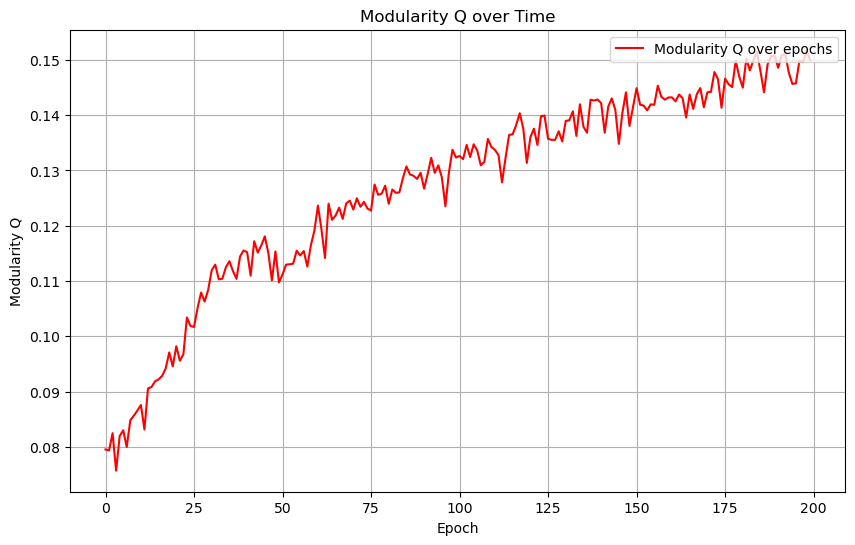

In [75]:
#### Visualise: modularity ####
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(modularity_q, label='Modularity Q over epochs', color='red')
plt.title('Modularity Q over Time')
plt.xlabel('Epoch')
plt.ylabel('Modularity Q')
plt.grid(True)
plt.legend()
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

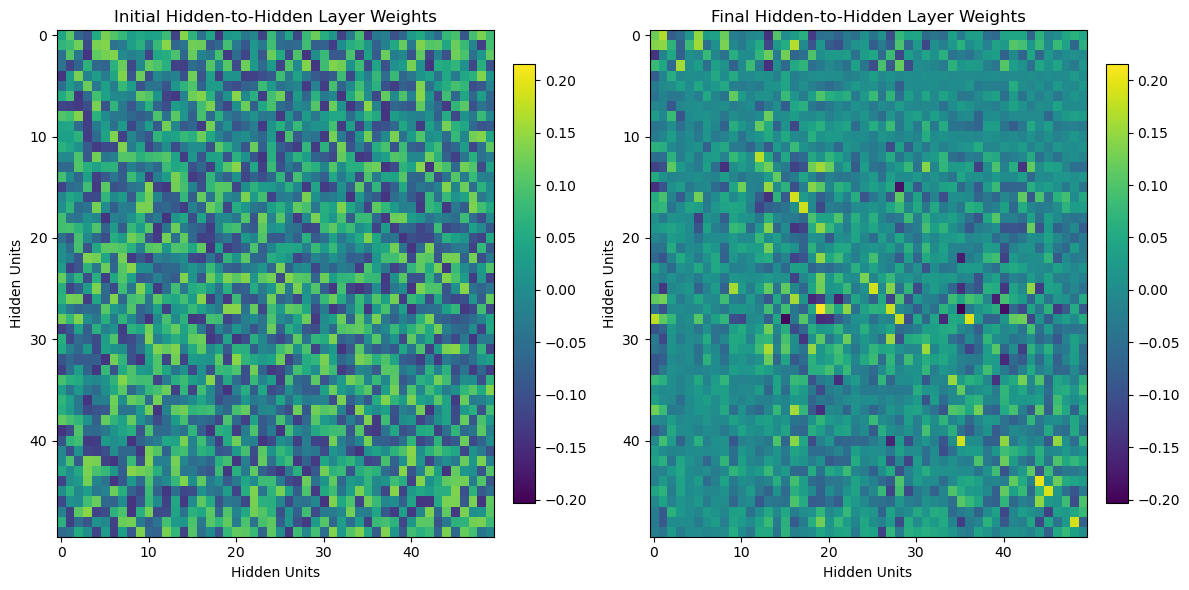

In [76]:
#### Visualise: weight matrices ####

# Visualization of the hidden-to-hidden weight matrices with the same color axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Determine global min and max values for consistent color axis across plots
vmin = min(initial_rnn_hh_weights.min(), final_rnn_hh_weights.min())
vmax = max(initial_rnn_hh_weights.max(), final_rnn_hh_weights.max())

# Intitial hidden-to-hidden weights visualization with consistent color axisy
cax1 = ax[0].imshow(initial_rnn_hh_weights, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax[0].set_title('Initial Hidden-to-Hidden Layer Weights')
ax[0].set_xlabel('Hidden Units')
ax[0].set_ylabel('Hidden Units')
fig.colorbar(cax1, ax=ax[0], fraction=0.046, pad=0.04)

# Final hidden-to-hidden weights visualization with consistent color axis
cax2 = ax[1].imshow(final_rnn_hh_weights, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax[1].set_title('Final Hidden-to-Hidden Layer Weights')
ax[1].set_xlabel('Hidden Units')
ax[1].set_ylabel('Hidden Units')
fig.colorbar(cax2, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

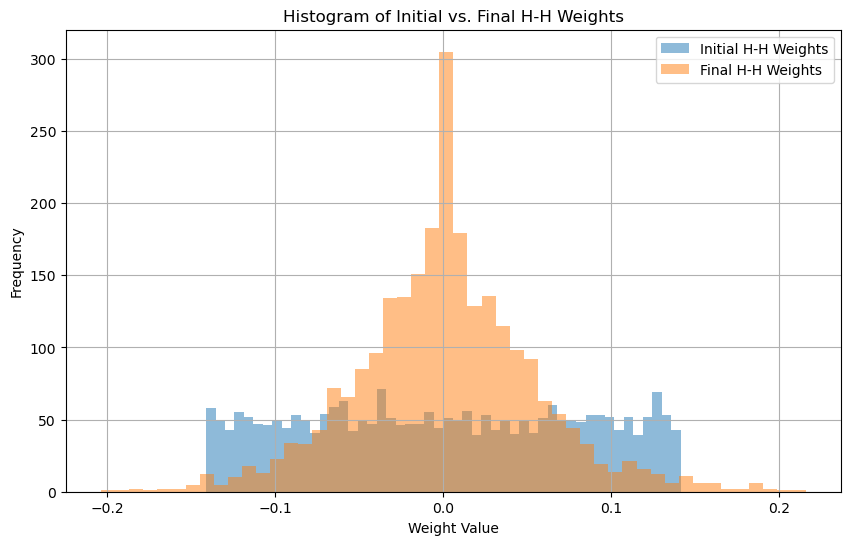

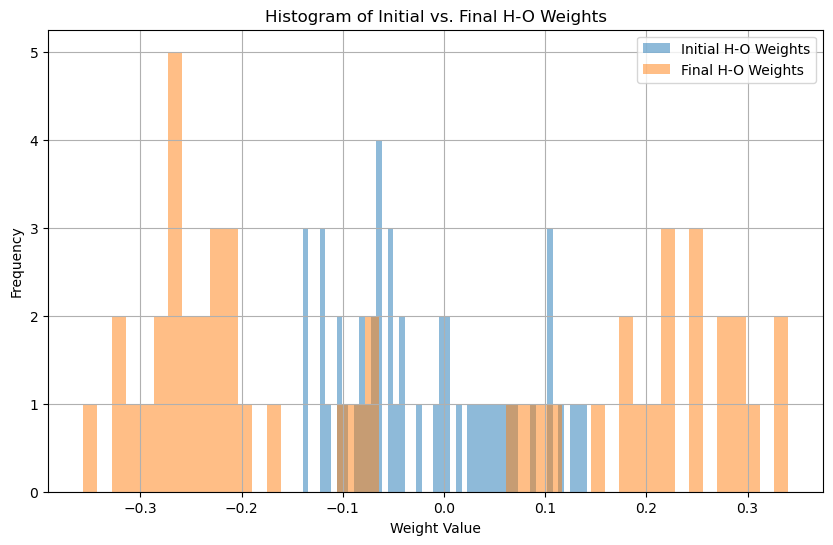

In [77]:
#### Visualise: weight histograms ####

# Plot the histogram of weights at beginning and end
# Flatten the weights to get them into a 1D array for histogram plotting
initial_weights_flat = initial_rnn_hh_weights.flatten()
final_weights_flat = final_rnn_hh_weights.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(initial_weights_flat, bins=50, alpha=0.5, label='Initial H-H Weights')
plt.hist(final_weights_flat, bins=50, alpha=0.5, label='Final H-H Weights')
plt.title('Histogram of Initial vs. Final H-H Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot the histogram of i-o weights at beginning and end
# Flatten the weights to get them into a 1D array for histogram plotting
initial_weights_flat = initial_rnn_ho_weights.flatten()
final_weights_flat = final_rnn_ho_weights.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(initial_weights_flat, bins=50, alpha=0.5, label='Initial H-O Weights')
plt.hist(final_weights_flat, bins=50, alpha=0.5, label='Final H-O Weights')
plt.title('Histogram of Initial vs. Final H-O Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

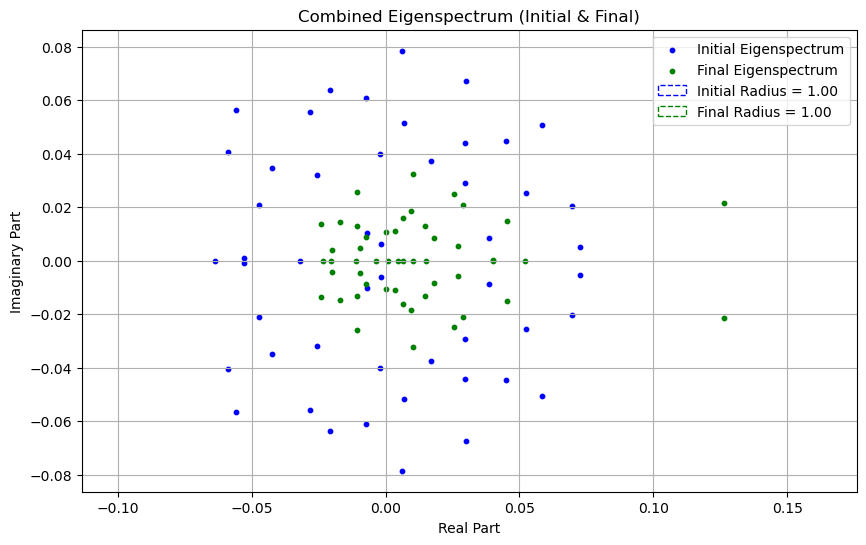

In [78]:
#### Visualise: eigenspectra ####

# Calculate the eigenvalues for the initial and final weights
eigenvalues_initial = np.linalg.eigvals(initial_rnn_hh_weights)
eigenvalues_final = np.linalg.eigvals(final_rnn_hh_weights)

# Normalize the eigenvalues by the square root of the hidden size
hidden_size = final_rnn_hh_weights.shape[0]  # Assuming square weight matrix for hidden-hidden weights
eigenvalues_initial_normalized = eigenvalues_initial / np.sqrt(hidden_size)
eigenvalues_final_normalized = eigenvalues_final / np.sqrt(hidden_size)

# Calculate radius based on some property (e.g., fixed or based on variance)
radius_initial = 1  # Example fixed radius, adjust as needed
radius_final = 1    # Example fixed radius, adjust as needed

# Initial Eigenspectrum
plt.figure(figsize=(10, 6))
plt.scatter(eigenvalues_initial_normalized.real, eigenvalues_initial_normalized.imag, s=10, color='blue', label='Initial Eigenspectrum')

# Final Eigenspectrum
plt.scatter(eigenvalues_final_normalized.real, eigenvalues_final_normalized.imag, s=10, color='green', label='Final Eigenspectrum')

# Add circles to indicate radius
circle_initial = plt.Circle((0, 0), radius_initial, color='blue', fill=False, linestyle='--', label=f'Initial Radius = {radius_initial:.2f}')
circle_final = plt.Circle((0, 0), radius_final, color='green', fill=False, linestyle='--', label=f'Final Radius = {radius_final:.2f}')
plt.gca().add_artist(circle_initial)
plt.gca().add_artist(circle_final)

# Setting the axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Adding grid, legend, and labels
plt.grid(True)
plt.legend()
plt.title('Combined Eigenspectrum (Initial & Final)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the circle a perfect circle
plt.show()

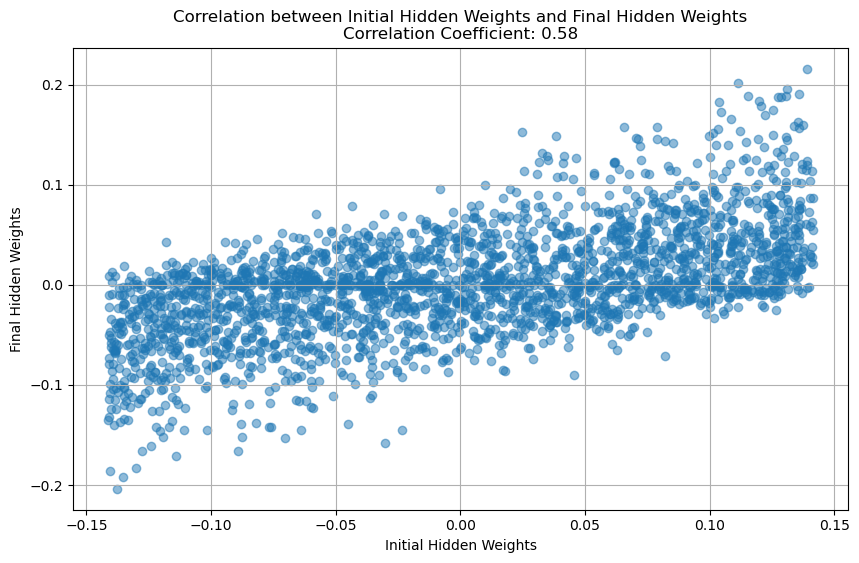

In [79]:
#### Visualise: Relationships - Initial v Final weights ####

# Plotting the relationship between initial and final weights
# Calculate the correlation coefficient
# Flatten the initial and final hh weights for easier handling
initial_weights_flat = initial_rnn_hh_weights.flatten()
final_weights_flat = final_rnn_hh_weights.flatten()

# Identify the indices of non-zero weights in the final hh weights
non_zero_indices = np.nonzero(final_weights_flat)

# Filter both initial and final hh weights to include only non-zero final hh weights
initial_weights_non_zero = initial_weights_flat[non_zero_indices]
final_weights_non_zero = final_weights_flat[non_zero_indices]

# Calculate the correlation coefficient for the non-zero final hh weights
correlation_coefficient_non_zero_final = np.corrcoef(initial_weights_non_zero, final_weights_non_zero)[0, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(initial_weights_non_zero, final_weights_non_zero, alpha=0.5)
plt.title(f'Correlation between Initial Hidden Weights and Final Hidden Weights\nCorrelation Coefficient: {correlation_coefficient_non_zero_final:.2f}')
plt.xlabel('Initial Hidden Weights')
plt.ylabel('Final Hidden Weights')
plt.grid(True)
plt.show()

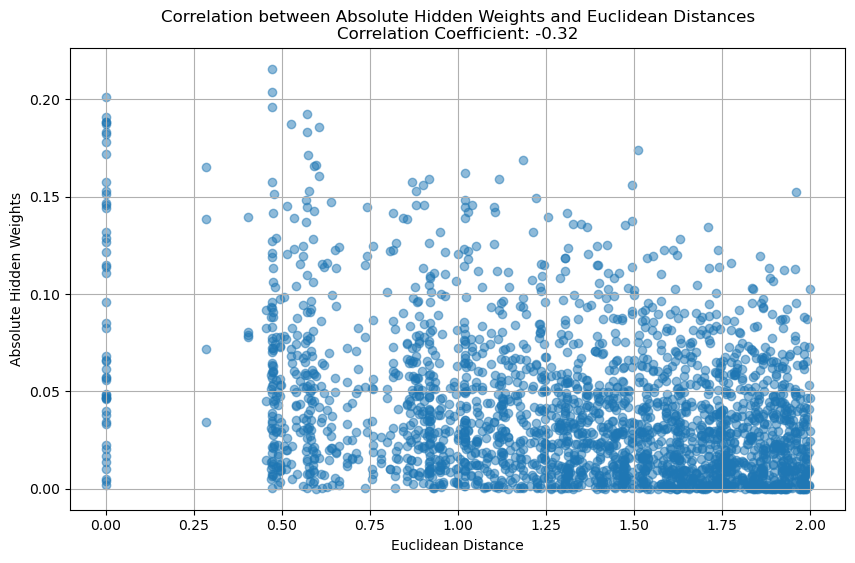

In [80]:
#### Visualise: Relationships - Weight v Distance ####

# Plotting the relationship between weights and distance
hidden_weights = model.rnn.weight_hh_l0.detach().numpy().flatten()
distance_matrix_3d = distance_matrix.numpy().flatten()

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(np.abs(hidden_weights), distance_matrix_3d)[0, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(distance_matrix_3d, np.abs(hidden_weights), alpha=0.5)
plt.title(f'Correlation between Absolute Hidden Weights and Euclidean Distances\nCorrelation Coefficient: {correlation_coefficient:.2f}')
plt.xlabel('Euclidean Distance')
plt.ylabel('Absolute Hidden Weights')
plt.grid(True)
plt.show()

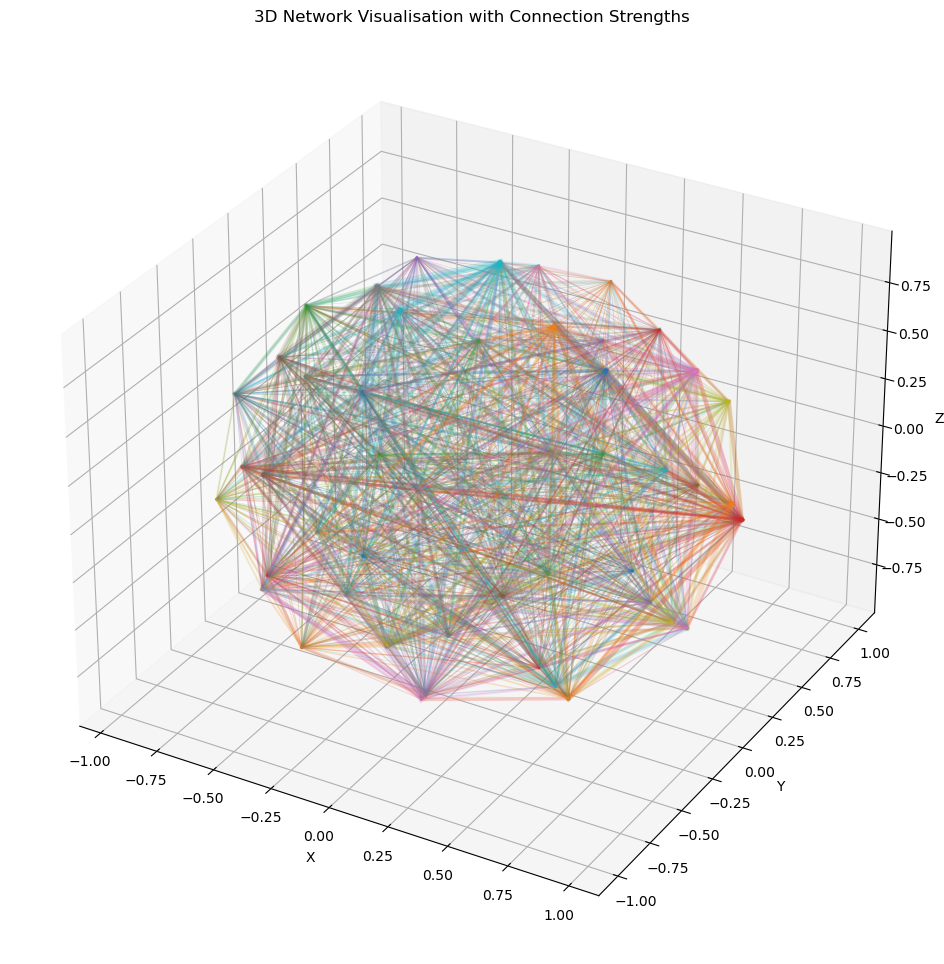

In [81]:
#### Visualise: 3D hidden-hidden weights graph ####

# Normalize weight strengths for plotting (to scale line widths)
weights = model.rnn.weight_hh_l0.detach().numpy()
weights_flat = weights.flatten()
# Scale weights to a more manageable range for visualization
weights_scaled = np.abs(weights_flat) / np.max(np.abs(weights_flat)) * 5  # Scale factor for visibility

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each connection
for i in range(hidden_size):
    for j in range(hidden_size):
        # Only plot significant connections
        if weights[i, j] != 0:
            # Determine start and end points
            start_pos, end_pos = positions[i], positions[j]
            # Compute a vector for the connection
            vec = end_pos - start_pos
            # Create a line segment from start to end point
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], [start_pos[2], end_pos[2]], 
                    linewidth=weights_scaled[i*hidden_size + j], alpha=0.2)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Network Visualisation with Connection Strengths')
plt.show()

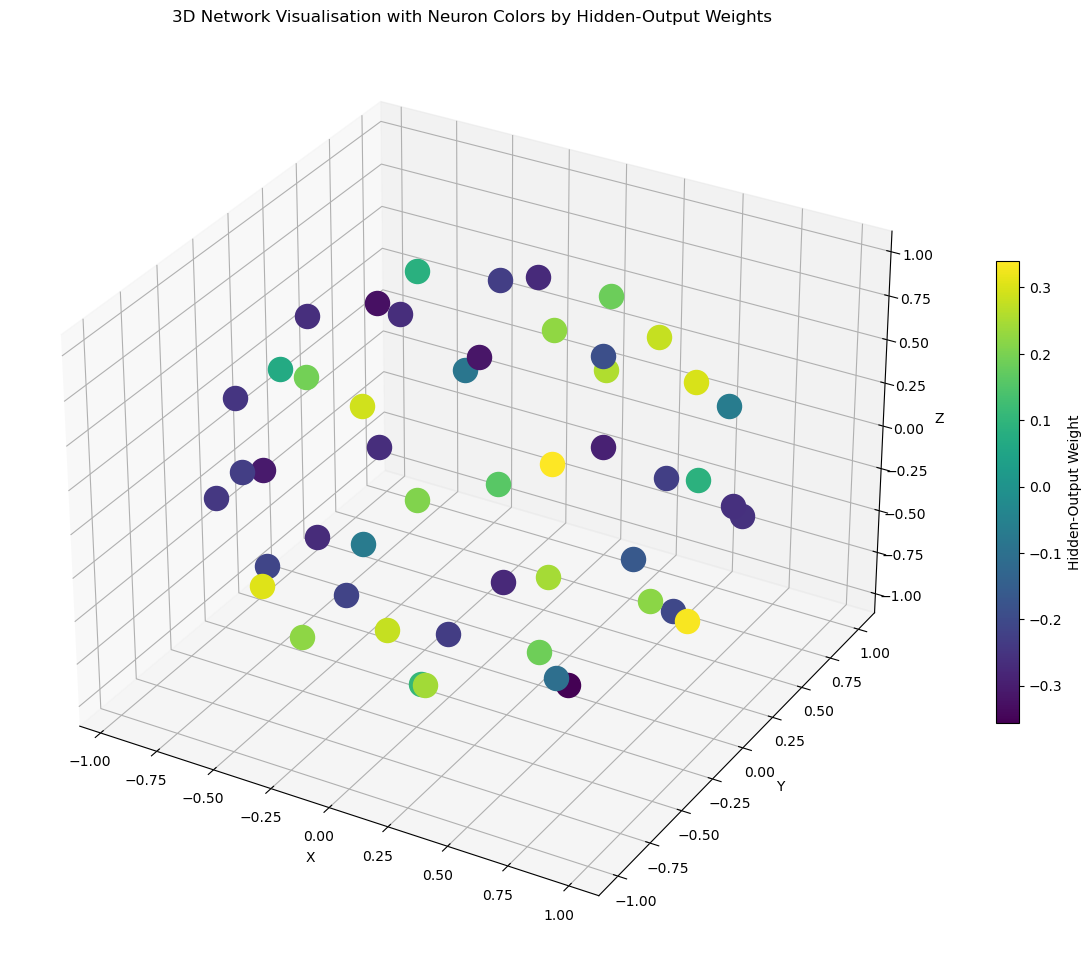

In [82]:
#### Visualise: 3D hidden-output weights graph ####

# Now the output weights distribution
hidden_output_weights = model.fc.weight.detach().numpy().squeeze()  # Squeeze in case of single output

# Normalize the weights for color mapping
# You might want to use an absolute value or other normalization depending on your use case
weights_normalized = (hidden_output_weights - np.min(hidden_output_weights)) / (np.max(hidden_output_weights) - np.min(hidden_output_weights))

# Create a colormap
cmap = plt.get_cmap('viridis')

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons with color based on hidden-output weight
for i, (x, y, z) in enumerate(positions):
    ax.scatter(x, y, z, color=cmap(weights_normalized[i]), s=300)  # s is the size of the point

# Optional: Add color bar to indicate weight values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(hidden_output_weights), vmax=np.max(hidden_output_weights)))
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.5, aspect=20, label='Hidden-Output Weight')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Network Visualisation with Neuron Colors by Hidden-Output Weights')
plt.show()

<IPython.core.display.Javascript object>


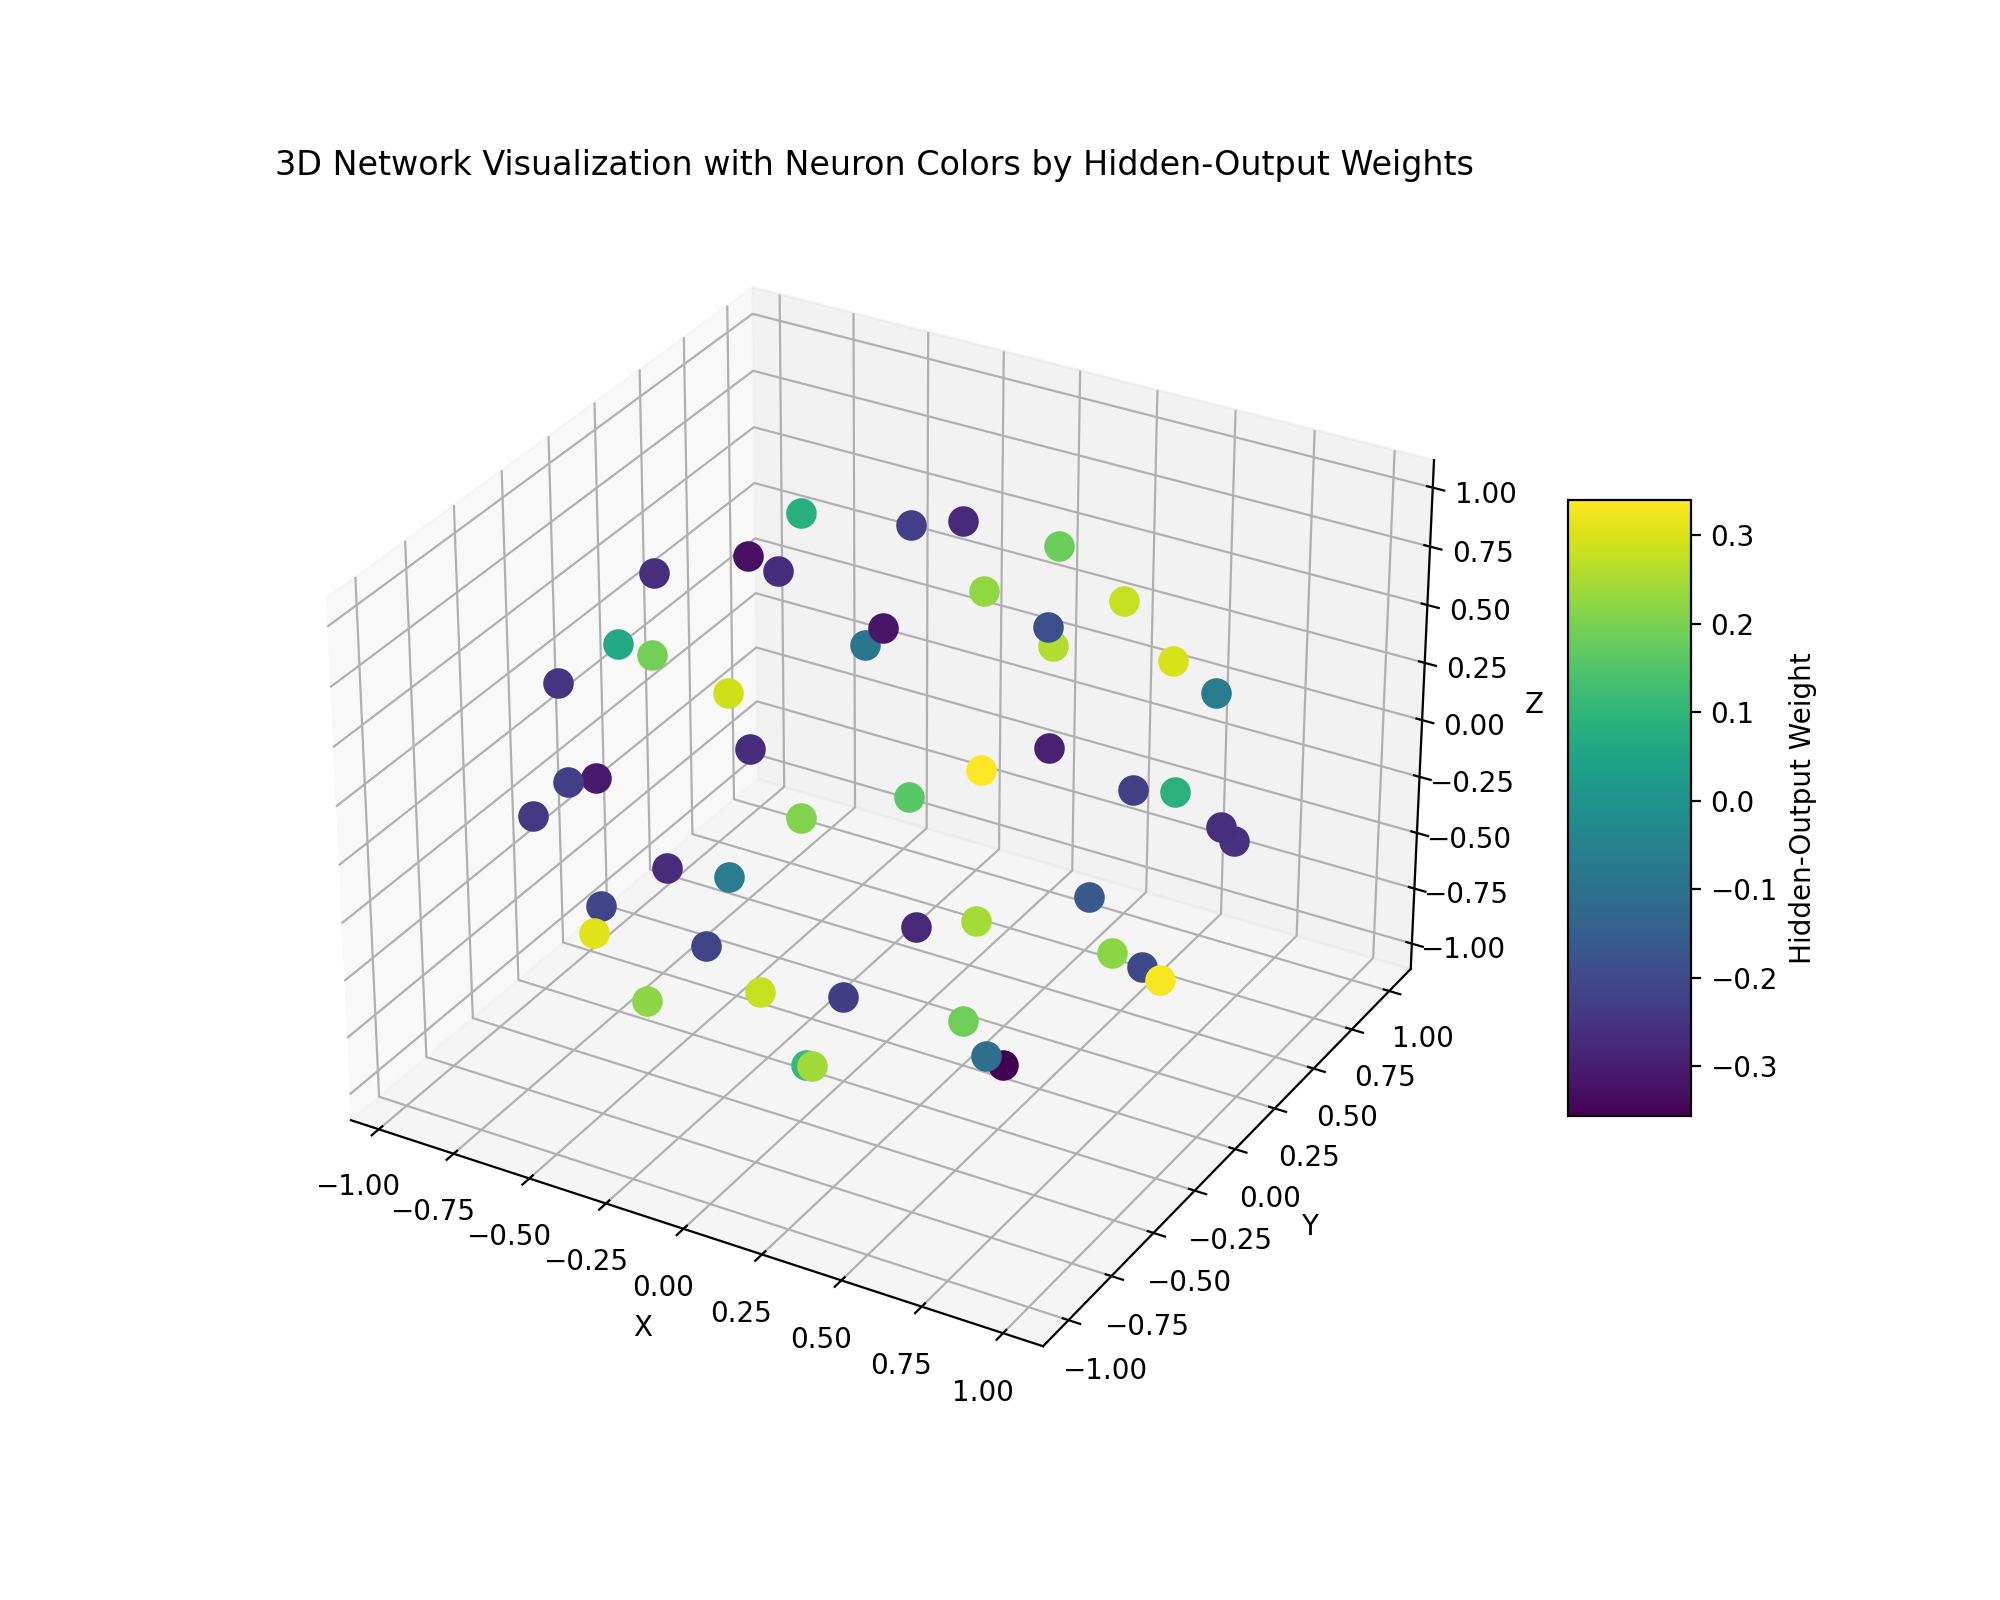

In [83]:
%matplotlib notebook
# Or use "%matplotlib widget" for newer environments with JupyterLab and an installed ipympl widget.

# Assuming 'positions' and 'model' are already defined
hidden_output_weights = model.fc.weight.detach().numpy().squeeze()

# Normalize the weights for color mapping
weights_normalized = (hidden_output_weights - np.min(hidden_output_weights)) / (np.max(hidden_output_weights) - np.min(hidden_output_weights))

# Create a colormap
cmap = plt.get_cmap('viridis')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons with color based on hidden-output weight
for i, (x, y, z) in enumerate(positions):
    ax.scatter(x, y, z, color=cmap(weights_normalized[i]), s=100)  # Adjust size as needed

# Optional: Add color bar to indicate weight values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(hidden_output_weights), vmax=np.max(hidden_output_weights)))
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.5, aspect=5, label='Hidden-Output Weight')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Network Visualization with Neuron Colors by Hidden-Output Weights')
plt.show()

# Revert back to inline plotting for subsequent plots
%matplotlib inline

<IPython.core.display.Javascript object>


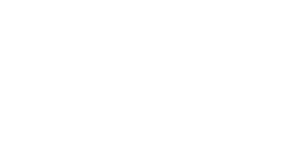

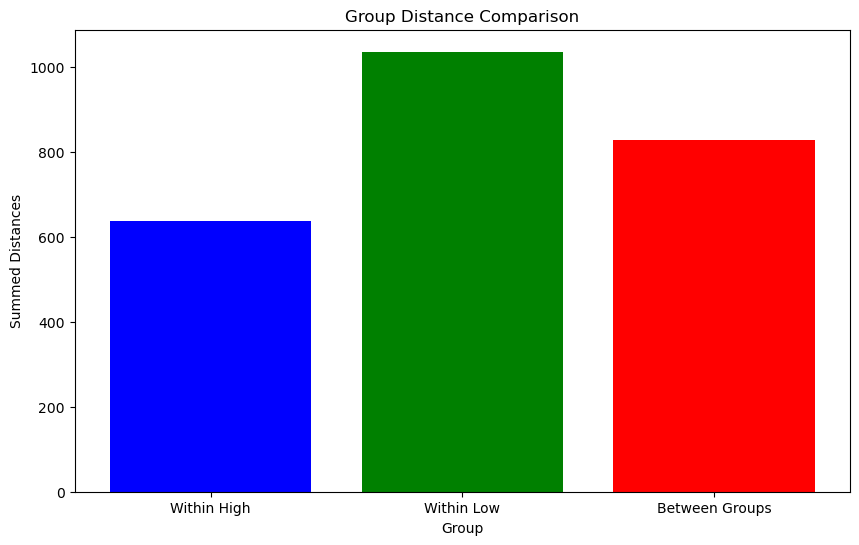

In [84]:
# Quick diagnostic to see if the hidden-output weights seperate spatially

# Assume model.fc.weight is your hidden-output weights tensor and distance_matrix is your distance matrix
hidden_output_weights = model.fc.weight.detach().numpy().squeeze()
distance_matrix_np = distance_matrix.numpy()  # Assuming distance_matrix is a PyTorch tensor

# Calculate the average weight
average_weight = np.mean(hidden_output_weights)

# Split weights into two groups
high_weight_indices = np.where(hidden_output_weights > average_weight)[0]
low_weight_indices = np.where(hidden_output_weights <= average_weight)[0]

# Calculate within-group distances
within_high_distance = np.sum(distance_matrix_np[high_weight_indices[:, None], high_weight_indices])
within_low_distance = np.sum(distance_matrix_np[low_weight_indices[:, None], low_weight_indices])

# Calculate between-group distances
between_groups_distance = np.sum(distance_matrix_np[high_weight_indices[:, None], low_weight_indices])

# Plotting the results
categories = ['Within High', 'Within Low', 'Between Groups']
values = [within_high_distance, within_low_distance, between_groups_distance]

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['blue', 'green', 'red'])
plt.title('Group Distance Comparison')
plt.ylabel('Summed Distances')
plt.xlabel('Group')
plt.show()